In [1]:
from Bio.PDB import *

import Bio.PDB as bpdb
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO
from Bio import SearchIO
from Bio.SeqUtils import seq1
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from Bio.PDB.Chain import Chain
from Bio.PDB.Atom import Atom
from Bio.PDB.Residue import Residue
from Bio.PDB.Model import Model

import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

import gudhi as gd
from scipy.optimize import minimize_scalar, least_squares

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d, gaussian_filter

import sys
import math

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

from daps import *

import nglview as nv

In [2]:
def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir

def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath


In [3]:
def get_files_with_ext(directory, ext):
    file_list = []
    for file in os.listdir(directory):
        if file.endswith(ext):
            file_list.append(file)
    return file_list

def get_geometries(directory):
    filenames = get_files_with_ext(directory, '.pdb')
    
    parser = PDBParser()
    geometries = {}
    for protein in filenames:
        name = os.path.splitext(protein)[0] # strip file extension
        chain = next(parser.get_structure('', os.path.join(directory, protein)).get_chains()) # 
        # chain = list(structure.get_chains())[0]
        geometries[name] = np.array([np.array(list(residue["CA"].get_vector())) for residue in chain.get_residues()])
        
    return geometries
        

In [4]:
def compromise(a, b):
    X = np.array([a,b])
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    Y = u @ vh
    return [*Y]

In [5]:
def visualize(*X):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for x in X:
        ax.plot(*x.T)

    plt.show()

In [6]:
def get_frame(dictionary, protid):
    preX = dictionary[protid]
    
    X = scipy.ndimage.gaussian_filter(preX, [1, 0]) # smoothed out curve
    dX = scipy.ndimage.gaussian_filter(X, [1, 0], order = 1) # tangent of backbone
    Y = scipy.ndimage.gaussian_filter(X, [20, 0]) # backbone
    dY = scipy.ndimage.gaussian_filter(Y, [1, 0], order = 1) # tangent of backbone
    dZ = dY / np.sqrt(np.sum(dY ** 2, axis = 1))[:, np.newaxis]
    
    V = np.zeros((len(dZ), 2, 3)) # V[i] is an orthonormal basis for the orthogonal complement of dZ[i]
    np.random.seed(100)
    V[0] = np.random.rand(2, 3)

    for i, z in enumerate(dZ):
        # project onto current tangent vector
        if i:
            V[i] = V[i-1]

        V[i] -= np.outer(V[i] @ z, z)
        V[i] = compromise(*V[i]) 

    Q = np.zeros((len(dZ), 4))
    for i in range(len(Q)):
        Q[i] = [(X[i] - Y[i]) @ V[i,0], (X[i] - Y[i]) @ V[i,1], (X[i] - Y[i]) @ dZ[i], dX[i] @ dZ[i]]

    return X, dX, Y, dY, dZ, V, Q

def get_winding(dictionary, protid):
    X, dX, Y, dY, dZ, V, Q = get_frame(dictionary, protid)
    
    s, c, q, dx = Q.T

    ds = gaussian_filter(s, 0.5, order = 1)
    dc = gaussian_filter(c, 0.5, order = 1)
    dq = gaussian_filter(q, 0.5, order = 1)

    r2 = s ** 2 + c ** 2

    summand = (c * ds - s * dc) / r2

    winding = np.cumsum(summand) / (2 * np.pi)
    
    # not in use currently:
    yaw = np.cumsum((c * dq - q * dc) / (q ** 2 + c ** 2)) / (2 * np.pi)
    roll = np.cumsum((s * dq - q * ds) / (s ** 2 + q ** 2)) / (2 * np.pi)
    
    return winding, s, c, q, dx


def projection(dictionary, protid):
    _, s, c, _, _ = get_winding(dictionary, protid)
    
    points = np.array([c, s]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    conf = range(len(s))
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
    norm = plt.Normalize(min(conf), max(conf))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(conf)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs, label = 'Residue number')

    plt.xlim(-21, 18)
    plt.ylim(-17, 12)
    # plt.savefig(make_path("plots", 'framing_projection_nlrome', f'{tairid}.png'), )
    # plt.close()
    plt.show()

    


def get_winding(dictionary, protid):
    X, dX, Y, dY, dZ, V, Q = get_frame(dictionary, protid)
    
    s, c, q, dx = Q.T

    ds = gaussian_filter(s, 1, order = 1)
    dc = gaussian_filter(c, 1, order = 1)
    dq = gaussian_filter(q, 1, order = 1)

    r2 = s ** 2 + c ** 2

    summand = (c * ds - s * dc) / r2

    winding = np.cumsum(summand) / (2 * np.pi)
    
    # not in use currently:
    yaw = np.cumsum((c * dq - q * dc) / (q ** 2 + c ** 2)) / (2 * np.pi)
    roll = np.cumsum((s * dq - q * ds) / (s ** 2 + q ** 2)) / (2 * np.pi)
    
    return winding, s, c, q, dx

def projection(dictionary, protid):
    _, s, c, _, _ = get_winding(dictionary, protid)
    
    points = np.array([c, s]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    conf = range(len(s))
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
    norm = plt.Normalize(min(conf), max(conf))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(conf)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs, label = 'Residue number')

    plt.xlim(-21, 18)
    plt.ylim(-17, 12)
    # plt.savefig(make_path("plots", 'framing_projection_nlrome', f'{tairid}.png'), )
    # plt.close()
    plt.show()

    


In [7]:
# find the most common slope
# search among all segments with width in [small, big)
# give greater weight to longer segments and to those that fit better

def median_slope(data, small, big):
    slopes = []
    weights = []
    for i in range(len(data) - small):
        for j in range(i + small, min(i + big, len(data))):
            s = (data[j]-data[i])/(j-i)
            slopes.append(s)
            reg = data[i:j] - s * np.arange(i,j)
            reg -= np.mean(reg)
            # weights.append(np.sqrt(j - i))
            weights.append((j - i) / (1 + np.sum(reg ** 2)))
    
    n_bins = int(np.sqrt(len(slopes)))
    scores = [0 for i in range(n_bins)]
    a = min(slopes)
    b = max(slopes) + 0.01
    # print(a, b, n_bins)
    
    # bin_vals = np.arange(a, b, (b - a) / n_bins)
    # assert len(bin_vals) == len(scores)
    
    for s, weight in zip(slopes, weights):
        bin_index = int(n_bins * (s - a) / (b - a))
        try:
            scores[bin_index] += weight
        except:
            print(bin_index, n_bins, s, a, b)
        
    return a + (np.argmax(scores) / n_bins) * (b - a), scores




In [8]:
# we will try to fit a piecewise function that is constant, then linear of slope m,
# then constant. we will attempt to minimize
# an L2 penalty. 

# we proceed by gradient descent 
# we control three parameters: the left and right endpoints of the linear region,
# and an "intercept" parameter for the line

#any number of breakpoints

def get_segs(winding, params, slope):
    segs = []
    
    breakpts = [0]+list(params)+[len(winding)]
    for ii, (a, b) in enumerate(zip(breakpts[:-1], breakpts[1:])):
        a = int(a)
        b = int(b)
        seg = np.array(winding[a:b])
        if ii%2:
            try:
                seg -= slope*np.arange(a, b)
            except:
                print(a, b, params, slope)
                print(seg)
                print((slope*np.arange(a, b)))
                raise Exception()
        seg -= np.mean(seg)
        segs.append(seg)

    return segs

def loss_multi(winding, params, slope, penalties):
    segs = get_segs(winding, params,slope)
    return np.sum([penalties[ii%2]*np.sum(seg**2) for ii,seg in enumerate(segs)])

def plot_regression_multi(winding, params, slope, save = False, filename = ''):
    segs = get_segs(winding, params, slope)

    plt.plot(winding)
    breakpts = [0]+list(params)+[len(winding)]
    for ii, (a, b) in enumerate(zip(breakpts[:-1], breakpts[1:])):    
        a = int(a)
        b = int(b)
        
        g = winding[a:b]
        plt.plot(range(a, b), g - segs[ii])
    if save:
        plt.savefig(filename + '.png')
        plt.close()
    else:
        plt.show()

#two breakpoints

def get_premidpost(winding, params, slope):
    l, r = params
    l = int(l)
    r = int(r)
    
    pre = np.array(winding[:l])
    pre -= np.mean(pre)
    mid = winding[l:r] - (slope * (np.arange(l, r)))
    mid -= np.mean(mid)
    post = np.array(winding[r:])
    post -= np.mean(post)
    
    return pre, mid, post

def loss(winding, params, slope, penalties):
    pre, mid, post = get_premidpost(winding, params,slope)
    return penalties[0] * np.sum(pre ** 2) + penalties[1] * np.sum(mid ** 2) + penalties[0] * np.sum(post ** 2)

def plot_regression(winding, params, slope, save = False, filename = ''):
    l, r = params
    l = int(l)
    r = int(r)    
    pre, mid, post = get_premidpost(winding, params, slope)

    plt.plot(winding)
    plt.plot(np.arange(l), winding[:l] - pre, c= 'red')
    plt.plot(np.arange(l, r), winding[l:r] - mid, c = 'green')
    plt.plot(np.arange(r, len(winding)), winding[r:] - post, c = 'purple')
    plt.title('Piecewise linear regression on winding number graph')
    plt.axvline(l, linestyle = '--', c= 'r')
    plt.axvline(r, linestyle ='--', c = 'purple')
    plt.xlabel('Residue number')
    plt.ylabel('Winding number')
    
    if save:
        plt.savefig(filename + '.png')
        plt.close()
    else:
        plt.show()


In [9]:
with open('pickles/cutoff_d.pickle', 'rb') as handle:
    cutoff_d = pickle.load(handle)    

## Running the pipeline

In [12]:
# run this once to load all structures into memory.
# A is a dictionary with with each key an IDs (filename with .pdb removed)
# and each value the numpy array defining the corresponding curve in R^3
A = get_geometries("nlrome_whole")

In [14]:
def get_curv_vectors(X, MaxOrder, sigma, loop = False, m = 'nearest'):

    from scipy.ndimage import gaussian_filter1d as gf1d
    if loop:
        m = 'wrap'
    XSmooth = gf1d(X, sigma, axis=0, order = 0, mode = m)
    Vel = gf1d(X, sigma, axis=0, order = 1, mode = m)
    VelNorm = np.sqrt(np.sum(Vel**2, 1))
    VelNorm[VelNorm == 0] = 1
    Curvs = [XSmooth, Vel]
    for order in range(2, MaxOrder+1):
        Tors = gf1d(X, sigma, axis=0, order=order, mode = m)
        for j in range(1, order):
            #Project away other components
            NormsDenom = np.sum(Curvs[j]**2, 1)
            NormsDenom[NormsDenom == 0] = 1
            Norms = np.sum(Tors*Curvs[j], 1)/NormsDenom
            Tors = Tors - Curvs[j]*Norms[:, None]
        Tors = Tors/(VelNorm[:, None]**order)
        Curvs.append(Tors)
    return Curvs

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def get_conf(tairid):
    parser = PDBParser()
    structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
    chain = list(structure.get_chains())[0]
    return [residue['CA'].get_bfactor() for residue in chain.get_residues()]

def estimate_coil_hmm(v1, v2, pcc=0.99, phh=0.99, muh=0, muc=0.7, sigma=0.3):

    ## Step 1: compute radius and max-normalize to [0, 1]

    r = np.sqrt(v1**2 + v2**2)
    r = r/np.max(r)
    
    ## Step 2: Setup transition probabilities for HMM
    # States: 0 - In hairpin
    #         1 - Not in hairpin
    ptrans = [[phh, 1-phh],
             [1-pcc, pcc]]
    ptrans = np.log(np.array(ptrans))


    ## Step 3: Viterbi algorithm
    r = np.concatenate(([0], r))
    N = len(r)
    P = np.zeros((2, N)) # Accumulated log probability matrix
    T = np.zeros((2, N), dtype=int) # Transition matrix

    for j in range(1, N):
        # Hairpin observation probability
        o1 = -(r[j]-muh)**2/(2*sigma**2)
        # Coil observation probability
        o2 = -(r[j]-muc)**2/(2*sigma**2)
        obs = [o1, o2]
        for i in range(2):
            ps = [0, 0]
            for k in range(2):
                ps[k] = P[k, j-1] + ptrans[k, i] + obs[i]
            T[i, j] = np.argmax(ps)
            P[i, j] = ps[T[i, j]]

    ## Backtracing
    i = 1
    states = [i]
    j = N-1
    while j > 0:
        i = T[i, j]
        states.append(i)
        j -= 1
    states.reverse()
    states = states[1::]
    return states


def get_hairpins(coil_est):
    hairpins = []
    N = len(coil_est)
    i1 = 0
    in_hairpin = coil_est[0] == 0
    for i in range(1, N):
        if in_hairpin and coil_est[i] == 1:
            hairpins.append([i1, i])
            in_hairpin = False
        elif not in_hairpin and coil_est[i] == 0:
            i1 = i
            in_hairpin = True
    return hairpins




def autocorr(x):
    """
    Fast autocorrelation based on the Wiener-Khinchin Theorem, which allows us
    to use the fast fourier transform of the input to compute the autocorrelation
    Parameters
    ----------
    x: ndarray(N)
        Array on which to compute the autocorrelation
    
    Returns
    -------
    ndarray(N): The autocorrelation
    """
    N = len(x)
    xpad = np.zeros(N*2)
    xpad[0:N] = x
    F = np.fft.fft(xpad)
    FConv = np.real(F)**2 + np.imag(F)**2 # Fourier transform of the convolution of x and its reverse
    return np.real(np.fft.ifft(FConv)[0:N])


In [15]:
df = pd.read_csv('LRRPredictor/col-0-nlrome.txt', delimiter = '\t')

motifs_d = {}
for protid in A:
    motifs = []
    foundProtein = False
    for ii in range(len(df)):
        if '.'.join(df['annotation'][ii].split('_')[1:]) == protid:
            foundProtein = True
        elif foundProtein:            
            break
        if foundProtein:
            motifs.append(int(df['start'][ii]))
    motifs_d[protid] = motifs

# with open('pickles/motifs_d.pickle', 'wb') as handle:
#     pickle.dump(motifs_d, handle)        

In [43]:
# # Todo: incorporate graph Laplacian methods in pipeline

# for protid in A:
#     period = 25
#     a, b = cutoff_d[protid]
#     X = A[protid][a:b]

#     X = get_curv_vectors(X, MaxOrder=1, sigma=1)[1]
#     # np.save(make_path('npy', 'nlrome_X', '%s.npy'%tairid), X)
            
#     #print out the number of residues in the chain, and print the locations of the LRR motif residues

#     D = get_csm(X, X)
#     # Clean up the matrix a bit by doing a sliding window of length roughly the period
#     D = sliding_window(D, period)
#     # Clean up the matrix even more by binarizing it with nearest neighbors
#     B = csm_to_binary_mutual(D, 50)
#     #B = B[0:400, 0:400]
#     v = getUnweightedLaplacianEigsDense(1-B)

#     plt.figure(figsize=(18, 6))
#     plt.subplot(131)
#     plt.imshow(D, cmap='magma_r')
#     plt.title("Self-Similarity Matrix")
#     plt.subplot(132)
#     plt.imshow(B)
#     plt.title("Binarized Self-Similarity Matrix")
#     plt.subplot(133)
#     plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
#     for motif in motifs_d[protid]:
#         motif -= a
#         if motif in range(v.shape[0]):
#             plt.axhline(motif)
#     plt.title("Eigenvectors of Unweighted Graph Laplacian")
#     # plt.show()
#     plt.savefig(make_path('fig','eigenmatrix_nlrome', '%s.png'%protid))
#     plt.close()

#     np.save(make_path('npy', 'eigenmatrix_nlrome', '%s.npy'%protid), v)


In [16]:
from scipy import stats
def mode_slope(data, small, big):
    slopes = []
    weights = []
    for i in range(len(data) - small):
        for j in range(i + small, min(i + big, len(data))):
            s = (data[j]-data[i])/(j-i)
            slopes.append(s)
    a = min(slopes)
    b = max(slopes)    
    n_bins = int(np.sqrt(len(slopes)))
    bins = np.linspace(a, b, n_bins)
    m, c = stats.mode(np.digitize(slopes,bins))
    return bins[m][0]


In [17]:
#sliding window of l2 distance
swms_d = {}
eigslope_d = {}
swl2_d = {}
for protid in A:
    # if protid != 'AT1G61180.1':
    #     continue
    v = np.load('npy/eigenmatrix_nlrome/%s.npy'%protid)
    s = v[:,0]
    c = v[:,1]
    ds = gaussian_filter(s, 1, order = 1)
    dc = gaussian_filter(c, 1, order = 1)
    r2 = s ** 2 + c ** 2
    summand = (c * ds - s * dc) / r2    
    winding = np.cumsum(summand) / (2 * np.pi)

    N = len(winding)
    slope = mode_slope(winding, 20, 30)
    # slope = median_slope(winding, 20, 30)[0]
    eigslope_d[protid] = slope

    flip = int(2*(int(slope>0)-.5))    

    M = 10
    swl2 = []
    for ii in range(len(winding) - M-1):
        res = winding[ii:ii+M]-slope*np.arange(ii,ii+M)
        res -= np.mean(res)
        swl2.append(np.linalg.norm(res))

    swl2_d[protid]= swl2

    # bins = np.linspace(min(swl2), max(swl2), 100)
    # scores = np.digitize(swl2, bins, 100)/100

    smoothened = scipy.ndimage.gaussian_filter(swl2, 2)

    offset = np.mean(winding - slope*np.arange(len(winding)))
    print

    plt.figure(figsize=(12, 6))
    plt.subplot(311)
    plt.plot(flip*s)
    plt.plot(flip*c)
    plt.title("Leading eigenvectors for %s"%protid)
    plt.subplot(312)
    plt.plot(flip*winding)
    plt.plot(flip*slope*np.arange(len(winding))-offset, c = 'grey', linestyle = '--')
    plt.title("Winding number vs median slope")
    plt.subplot(313)
    plt.plot(swl2)
    plt.title("Sliding window L2 distance")    
    plt.tight_layout()            

    # plt.show()
    # break
    plt.savefig(make_path('plots', 'swl2', f'{protid}.png'))
    plt.close()
    

In [186]:
#save LRR region only as pdb
'''
for protid in A:
    parser = PDBParser()
    structure = parser.get_structure(protid, 'nlrome_whole/%s.pdb'%protid)

    chain = list(structure.get_chains())[0]
    a, b = cutoff_d[protid]

    class ResSelect(bpdb.Select):
        def accept_residue(self, res):
            if res.id[1] >= a and res.id[1]<= b:
                return True
            else:
                return False            
    io = bpdb.PDBIO()       
    io.set_structure(chain)
    io.save(make_path('nlrome_LRR','%s.pdb'%protid), ResSelect())       

'''    

In [23]:
scheme

[['#b6308b', '508.93751976570695-508.93751976570695'],
 ['#b02991', '509.93751976570695-509.93751976570695'],
 ['#9d189d', '510.93751976570695-510.93751976570695'],
 ['#8104a7', '511.93751976570695-511.93751976570695'],
 ['#6700a8', '512.937519765707-512.937519765707'],
 ['#5901a5', '513.937519765707-513.937519765707'],
 ['#5601a4', '514.937519765707-514.937519765707'],
 ['#5502a4', '515.937519765707-515.937519765707'],
 ['#43039e', '516.937519765707-516.937519765707'],
 ['#330597', '517.937519765707-517.937519765707'],
 ['#2f0596', '518.937519765707-518.937519765707'],
 ['#350498', '519.937519765707-519.937519765707'],
 ['#3a049a', '520.937519765707-520.937519765707'],
 ['#38049a', '521.937519765707-521.937519765707'],
 ['#38049a', '522.937519765707-522.937519765707'],
 ['#3f049c', '523.937519765707-523.937519765707'],
 ['#4903a0', '524.937519765707-524.937519765707'],
 ['#5102a3', '525.937519765707-525.937519765707'],
 ['#5601a4', '526.937519765707-526.937519765707'],
 ['#5601a4', '5

In [25]:
protid = 'AT1G17600.1'
pdb_parser = PDBParser()
structure = pdb_parser.get_structure(protid, f"nlrome_LRR/{protid}.pdb")

#setting the color
viridis = plt.cm.viridis
cmap = plt.cm.get_cmap('plasma')

a, b = np.array(cutoff_d[protid]).astype('int')

f = swl2_d[protid]
# bins = np.linspace(min(f), max(f), 100)
# scores = np.digitize(f, bins, 100)/100

scheme = []

for ii, dist in enumerate(f):
    ii += a + 20
    scheme += [[matplotlib.colors.rgb2hex(cmap(np.min([4*dist, 1]))), f"{ii}-{ii}"]]

nv.color.ColormakerRegistry.add_selection_scheme(
    "my_custom_scheme", scheme
)

view = nv.show_biopython(structure, default_representation=False)
view.add_cartoon(color="my_custom_scheme")
view.center()
view.download_image(filename=f'plots/hairpin_ngl/{protid}.png')
view

NGLWidget()

In [261]:
protid = 'AT1G56540.1'
pdb_parser = PDBParser()
structure = pdb_parser.get_structure(protid, f"nlrome_LRR/{protid}.pdb")

# chain = list(list(structure.get_models())[0].get_chains())[0]

a, b = cutoff_d[protid]

scheme = []
prev = 0
for motif in [pos for pos in motifs_d[protid] if pos <b]:
    scheme += [['#fde725', f"{prev}-{motif-1}"], ["red", f"{motif}-{motif}"]]
    prev = motif+1
if motif < b:
    scheme.append(["blue", f"{prev}-{b}"])

nv.color.ColormakerRegistry.add_selection_scheme(
    "my_custom_scheme", scheme
)

view = nv.show_biopython(structure, default_representation=False)
view.add_cartoon(color="my_custom_scheme")
view.center()
view

NGLWidget()

In [132]:

# Load the protein structure
# view = nv.show_structure_file("nlrome_whole/AT1G56540.1.pdb")

# Define the list of colors
color_list = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']

# Iterate over each residue and set its color
for i, residue in enumerate(view.structure.residues):
    color_index = i % len(color_list)
    residue.color = color_list[color_index]

# Auto-center and zoom the view
view.center()
view.add_representation('cartoon')
view.update_representation()

AttributeError: 'NGLWidget' object has no attribute 'residues'

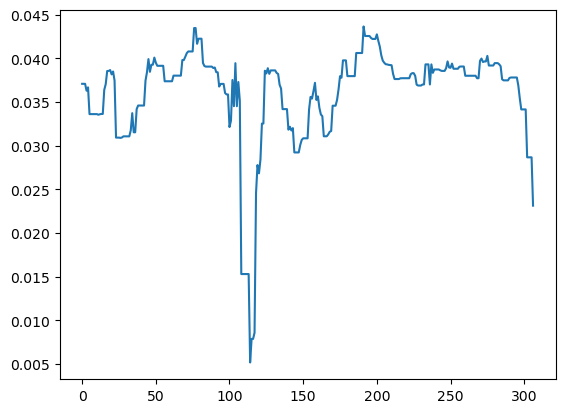

In [80]:
X

In [122]:
#generate eigenvector plots
for protid in A:
    motifs_l = motifs_d[protid]
    period = 25

    # if protid != 'AT1G58602.1':
    #     continue
    for eig1, eig2 in [(0,1)]:
        v = np.load('npy/eigenmatrix_nlrome/%s.npy'%protid)

        # plt.figure(figsize=(12, 4))
        s = v[:,eig1]
        c = v[:,eig2]

        # plt.show()
        # Detrend with daps
        sf = detrend_timeseries(s, period)
        cf = detrend_timeseries(c, period)

    # print(.shape)
    X=v[:, eig1:eig2+1]

    # windowSize = 25
    # totpers_l=[]
    # for windowStart in range(X.shape[0]- windowSize-1):
    #     Y = X[windowStart:windowStart+windowSize,:]
    #     stree = gd.AlphaComplex(points = Y).create_simplex_tree()
    #     dgm = stree.persistence()
    #     dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
    #     dgmstat = sum(dgm1_lens)
    #     # gd.plot_persistence_diagram(dgm, legend = True)
    #     totpers_l.append(dgmstat)     
    # plt.figure(figsize=(12, 6))
    # plt.plot(totpers_l)
    # plt.show()
    # plt.close()

    r = np.sqrt(s**2+c**2)
    r = r/np.max(r)
    coil_est = estimate_coil_hmm(s, c)
    print(get_hairpins(coil_est))


    plt.figure(figsize=(12, 6))
    plt.subplot(311)
    plt.plot(s)
    plt.plot(c)
    plt.title("Leading eigenvectors for %s"%protid)
    plt.subplot(312)
    plt.plot(r)
    plt.title("Normalized radius")
    plt.subplot(313)
    plt.plot(coil_est)
    plt.title("Coil Estimate")
    plt.tight_layout()    
    # plt.show()

    plt.savefig(make_path('plots','hairpin_nlrome', '%s.png'%protid))
    
    plt.close()

    theta = np.arctan2(cf, sf)
    plt.figure(figsize=(12, 4))
    plt.plot(theta, label=f'{eig1}, {eig2}')
    plt.close()
  

[]
[[0, 10], [247, 255], [303, 310]]
[]
[]
[]
[]
[[218, 234], [276, 288]]
[[0, 9], [223, 276]]
[[0, 24], [425, 458]]
[[409, 441]]
[[0, 17], [261, 269], [405, 464]]
[[0, 15]]
[[110, 127], [309, 318]]
[[40, 58], [332, 351]]
[[0, 37], [303, 329]]
[[29, 43]]
[[246, 290]]
[]
[]
[[0, 105], [556, 573]]
[[0, 116], [439, 475]]
[[0, 147], [484, 500]]
[[0, 147], [484, 500]]
[[354, 361]]
[[211, 230], [359, 373]]
[[208, 230], [274, 280]]
[[209, 227]]
[[39, 55], [281, 291], [371, 380]]
[[278, 285], [364, 386]]
[[36, 50], [277, 285]]
[[0, 7], [235, 264], [335, 446]]
[[224, 253]]
[[0, 52], [316, 353]]
[[0, 40], [63, 79], [348, 365]]
[[322, 342]]
[[13, 39]]
[[37, 54]]
[[35, 58], [326, 344]]
[[0, 15], [59, 73], [350, 378]]
[[0, 108], [694, 832]]
[[0, 86], [155, 188], [199, 248]]
[[309, 323]]
[[0, 14], [35, 61], [285, 319]]
[[0, 51], [178, 193], [405, 418]]
[[366, 484]]
[[0, 125], [230, 245], [330, 346], [526, 541]]
[[0, 85], [337, 349]]


KeyboardInterrupt: 